# 使用 Transformer 的计算机视觉


在本教程中，我们将使用 Hugging Face 的 Transformers 库处理图像。为了避免笔记本过载，部分函数已存放在 `utils/util.py` 中。


## 零样本对象检测（Zero-Shot）


图像中的对象检测是计算机视觉中的一项核心任务。**零样本模型**非常实用，因为它们无需微调即可检测任意对象。只需提供一张图像和包含要检测类别的文本提示即可。


### 实现步骤


我们选择了谷歌的 **OWL-ViT 模型**（`google/owlvit-base-patch32`），因为它轻量且适用于大多数设备。我们将使用 Hugging Face 的 **pipeline** 进行实现：


In [1]:
from transformers import pipeline
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

zeroshot = pipeline("zero-shot-object-detection", model="google/owlvit-base-patch32")

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


首先，我们来看一下待处理的图像。


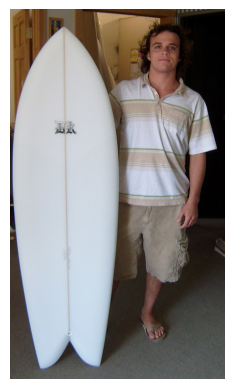

In [119]:
image=Image.open("images/coco.jpg") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

接下来，我们将使用模型绘制预测的检测框。


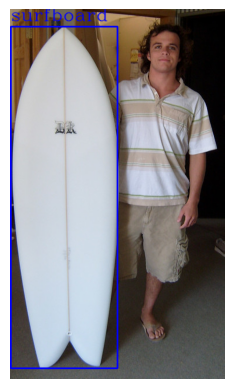

In [120]:
from utils.util import draw_box

text_prompt = "surfboard" # Vous pouvez changer la classe pour détecter autre chose "person" ou "surfboard"
output = zeroshot(image,candidate_labels = [text_prompt])
cv_image=draw_box(image,output)

plt.imshow(cv_image)
plt.axis('off') 
plt.show()

现在，您已经学会如何用几行代码实现一个**零样本对象检测器**了。


## 图像描述生成


**图像描述生成**是指为图像自动生成文本描述。模型接收图像作为输入，并输出对应的描述文本。


### 实现步骤


同样，我们使用 Hugging Face 的 pipeline。此处采用 **Salesforce 的 BLIP 模型**（`Salesforce/blip-image-captioning-base`）。


In [121]:
captionner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")

我们将使用同一张图像生成描述。


In [122]:
result=captionner(image)
print(result[0]['generated_text'])

a man holding a surfboard in a room


模型生成的描述为“一个男子在房间里拿着冲浪板”，这与图像内容相符。
现在，您已经学会如何生成图像描述。这在自动创建数据集时非常有用。


## 零样本图像分类（Zero-Shot）


除了零样本对象检测，我们还可以进行**零样本图像分类**。原理类似，但这次我们需要提供**至少两个文本描述**，模型将给出图像分别对应每个描述的概率。


### 实现步骤


我们将使用一张我的猫的照片来判断它的品种：


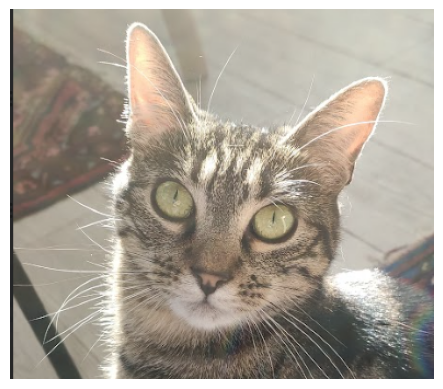

In [123]:
image=Image.open("images/tigrou.png") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

我们将测试模型是否能判断它是**缅因猫**还是**欧洲短毛猫**。


我们将使用 OpenAI 的 **CLIP 模型**（`openai/clip-vit-base-patch32`）。为了展示多样性，此处我们将直接调用 Hugging Face 库的其他函数，而非使用 pipeline。


In [125]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-base-patch32")

/home/aquilae/anaconda3/envs/dev/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [133]:
labels = ["a photo of a european shorthair", "a photo of maine coon"]
inputs = processor(text=labels,images=image,return_tensors="pt",padding=True)
outputs = model(**inputs)

# Transformation des outputs pour obtenir des probabilités
print("Probabilité de a photo of a european shorthair : ",outputs.logits_per_image.softmax(dim=1)[0][0].item())
print("Probabilité de a photo of maine coon : ",outputs.logits_per_image.softmax(dim=1)[0][1].item())

Probabilité de a photo of a european shorthair :  0.9104425311088562
Probabilité de a photo of maine coon :  0.08955750614404678


模型相当确信这是一只欧洲短毛猫，而实际上它判断正确。


## 图像分割


在这个示例中，我们将使用 Meta 的 **SAM 模型**，它能够分割图像中的任意对象。


### 实现步骤


In [2]:
sam = pipeline("mask-generation","Zigeng/SlimSAM-uniform-77")

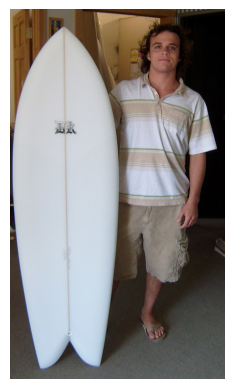

In [3]:
image=Image.open("images/coco.jpg") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

In [8]:
# ATTENTION : le traitement peut prendre plusieurs minutes
output=sam(image, points_per_batch=32)

In [5]:
masks=output["masks"]

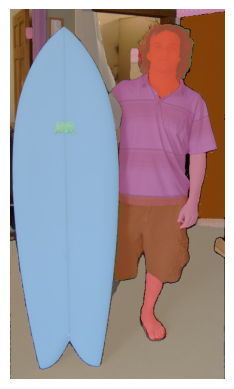

In [7]:
from utils.util import draw_masks
image_np=draw_masks(image,masks)

plt.imshow(image_np)
plt.axis('off') 
plt.show()

如您所见，我们已经分割出了图像中的所有对象。不过，处理时间较长...
为了获得更合理的推理时间，我们可以使用**图像中某一点的坐标提示**。这能够指定处理区域并加快结果生成速度。
注意：Hugging Face 的 pipeline **不支持**这一任务。


In [9]:
from transformers import SamModel, SamProcessor

In [10]:
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")

现在，我们创建坐标提示并可视化该点：


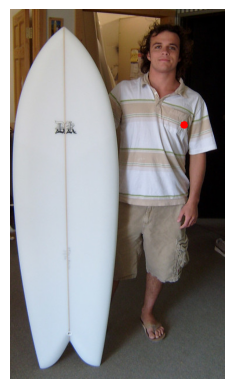

In [41]:
input_points = [[[300, 200]]]
image_np= np.array(image)
cv2.circle(image_np,input_points[0][0],radius=3,color=(255,0,0),thickness=5)
plt.imshow(image_np)
plt.axis('off')
plt.show()

In [44]:
inputs = processor(image,input_points=input_points,return_tensors="pt")
outputs = model(**inputs)
predicted_masks = processor.image_processor.post_process_masks(
  outputs.pred_masks,
  inputs["original_sizes"],
  inputs["reshaped_input_sizes"]
)

处理速度明显加快！
SAM 默认生成 **3 个掩码**。每个掩码代表一种可能的图像分割方式。您可以修改 **`mask_number`** 的值来查看不同的掩码。


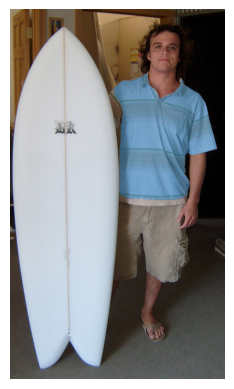

In [46]:
mask_number=2 # 0,1 or 2
mask=predicted_masks[0][:, mask_number] 
image_np=draw_masks(image,mask)
plt.imshow(image_np)
plt.axis('off') 
plt.show()

在这个示例中，3 个掩码都很合理：
- 第 1 个掩码分割了整个人
- 第 2 个掩码分割了衣服
- 第 3 个掩码仅分割了 T 恤

您可以尝试更改坐标点，观察生成的不同掩码。


## 深度估计


**深度估计**是计算机视觉中的一项关键任务。它在以下场景中非常有用：
- **自动驾驶**：估计与前方车辆的距离
- **工业应用**：根据剩余空间组织包裹中的物品

在这个示例中，我们使用 **Intel 的 DPT 模型**（`Intel/dpt-hybrid-midas`），它接收图像输入并输出**深度图**。


### 实现步骤


In [47]:
depth_estimator = pipeline(task="depth-estimation",model="Intel/dpt-hybrid-midas")

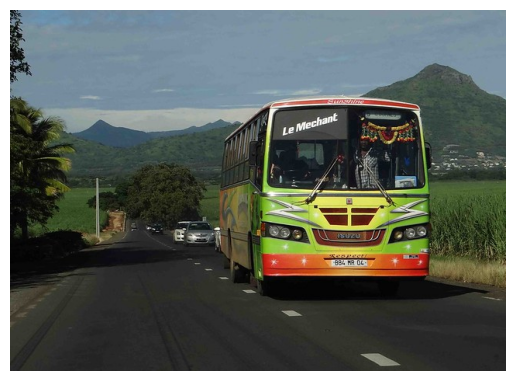

In [48]:
image=Image.open("images/coco2.jpg") # Image extraite de la base de données COCO (https://cocodataset.org/#home)

plt.imshow(image)
plt.axis('off')  
plt.show()

In [57]:
outputs = depth_estimator(image)
outputs["predicted_depth"].shape

torch.Size([1, 384, 384])

我们使用 PyTorch 将预测的深度图尺寸调整为与原始图像一致，然后生成深度图的可视化图像。


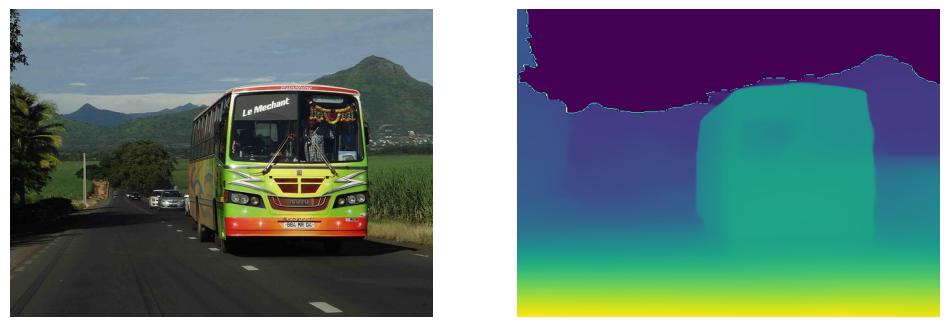

In [60]:
import torch 
prediction = torch.nn.functional.interpolate(outputs["predicted_depth"].unsqueeze(1),size=image.size[::-1],
                                             mode="bicubic",align_corners=False)
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6)) 
ax1.imshow(image)
ax1.axis('off')  
ax2.imshow(depth)
ax2.axis('off')  
plt.show()

在深度图中，**明亮的颜色**代表距离更近的对象。可以清楚地看到：
- 道路（非常明亮）距离最近
- 公交车（较明亮）距离稍远

因此，该深度图的精度较高。
